In [1]:
from data_pipeline.modular_data_extraction import create_data_packages
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms
from data_pipeline.ukb_data_extractor import UkbDataExtractor
import data_pipeline.data_processing_utils as dpu

from data_pipeline.data_package import DataPackage
from data_pipeline.odir_5k_data_extractor import ODIR5KDataExtractor
from data_pipeline.rfmid_data_extractor import RFMiDDataExtractor
from data_pipeline.rfmid2_data_extractor import RFMiD2DataExtractor
from data_pipeline.ukb_data_extractor import UkbDataExtractor
from data_pipeline.rips_data_extractor import RIPSDataExtractor
from data_pipeline.ses_data_extractor import SESDataExtractor
from data_pipeline.one_thousand_images_data_extractor import OneThousandImagesDataExtractor

from data_pipeline.data_processing_utils import standardize_labels
from data_pipeline.data_processing_utils import create_one_hot_encoder
import data_pipeline.data_processing_utils as dpu
import data_pipeline.data_splitting_utils as dsu



from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
import numpy as np

from convert_user_inputs import convert_user_input, create_datasets
from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
from datetime import datetime
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
model_key = 'resnet18'
transform_type = 'ben'

dataset_name = '2024-02-23-13-31-39'
dataset_path = f'datasets/{dataset_name}'

In [3]:
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophie or Cone-rod Dystrophie", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease"])

In [5]:
ukb_database_path = 'databases/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx'
ukb_data_path ='databases/ird_dataset/export_heyex_original_dataset_03/DICOM'
ukb_extractor = UkbDataExtractor(database_path=ukb_data_path, label_path=ukb_database_path)

odir5k_data_extractor = ODIR5KDataExtractor(database_path='databases/ODIR-5K/full_df.csv', database_test_images_path='databases/ODIR-5K/Testing Images',
                                                database_train_images_path='databases/ODIR-5K/Training Images')

rfmid_train_data_extractor = RFMiDDataExtractor(database_path='databases/RFMiD/Training_Set/RFMiD_Training_Labels.csv',
                                            data_path='databases/RFMiD/Training_Set/Training', file_format='png')

rfmid_validation_datae_xtractor = RFMiDDataExtractor(database_path='databases/RFMiD/Evaluation_Set/RFMiD_Validation_Labels.csv',
                                            data_path='databases/RFMiD/Evaluation_Set/Validation', file_format='png')

rfmid_test_data_extractor = RFMiDDataExtractor(database_path='databases/RFMiD/Test_Set/RFMiD_Testing_Labels.csv',
                                                data_path='databases/RFMiD/Test_Set/Test', file_format='png')

rfmid2_train_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Training_set/RFMiD_2_Training_labels.csv',
                                                    data_path='databases/RFMiD2_0/Training_set')
rfmid2_validation_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Validation_set/RFMiD_2_Validation_labels.csv',
                                                            data_path='databases/RFMiD2_0/Validation_set')

rfmid2_test_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Test_set/RFMiD_2_Testing_labels.csv',
                                                        data_path='databases/RFMiD2_0/Test_set')


one_thousand_images_data_extractor = OneThousandImagesDataExtractor(database_path='databases/1000images/')

rips_data_extractor = RIPSDataExtractor(database_path='databases/RIPS/Original')

ses_data_extractor = SESDataExtractor(database_path='databases/SES/')


In [6]:
#create the data extraction list
default_data_extractors = [odir5k_data_extractor, rfmid_train_data_extractor, rfmid_validation_datae_xtractor, rfmid_test_data_extractor,
                    rfmid2_train_data_extractor, rfmid2_validation_data_extractor, rfmid2_test_data_extractor,
                    one_thousand_images_data_extractor, rips_data_extractor, ses_data_extractor]

dicom_data_extractors = [ukb_extractor]

data_extractors = default_data_extractors + dicom_data_extractors


In [7]:
#extract the data
for data_extractor in data_extractors:
    data_extractor.extract()

#standardize the data
#get the labels of the data
datasets_labels = []
for data_extractor in data_extractors:
    datasets_labels.append(data_extractor.get_labels())
#flatten
labels = []
for dataset_labels in datasets_labels:
    labels.extend(dataset_labels)
#concatenate the labels
labels = np.concatenate(labels)
#drop the None values
labels = labels[labels != None]

In [8]:
not_summarize_set = set(RFMiD2DataExtractor.abbreviation_map.values())
ukb_label_mapping_dict = {'Morbus Best': 'Best Disease', 'Morbus Stargardt': 'Stargardt Disease', 'Retinitis pigmentosa': 'Retinitis Pigmentosa'}
label_standertizer = standardize_labels(labels = labels, not_summarize_set=not_summarize_set)
label_standertizer.update(ukb_label_mapping_dict)

In [9]:
#value count the labels
label_counts = pd.Series(labels).value_counts()
#get the median label count
median_label_count = label_counts.median()
label_instance_limit = int((max(label_counts) - median_label_count) // 4)
#balance the labels
#find the over represented labels
for labels,extractor in zip(datasets_labels, data_extractors):
    #find the over represented labels
    #replace none with empty string
    over_represented_labels_idxs, _, _ = dpu.find_over_represented_samples(file_paths=extractor.get_file_paths(), labels=labels,
                                                                            max_samples_per_class=label_instance_limit)
    #remove the over represented labels
    #conver the indexes to a boolean array
    over_represented_labels_series = np.isin(np.arange(len(labels)), over_represented_labels_idxs)
    extractor.extracted_data = extractor.extracted_data[~over_represented_labels_series]

In [10]:
#split the data stratified by the labels
train_portion = 0.7
val_portion = 0.1
test_portion = 0.2
split_portions = [train_portion, val_portion, test_portion]

In [11]:
splits = []
for data_extractor in data_extractors:
    splits.extend(data_extractor.split_extracted_data(split_portions = split_portions, stratify=True))

In [12]:
lambda_strip = lambda x: x.strip() if isinstance(x, str) else x
label_translation = lambda x: label_standertizer.get(x, x)
for i, split in enumerate(splits):
    #strip trailing and leading whitespaces
    #split.labels = np.vectorize(lambda_strip)(split.labels)
    split.labels = np.vectorize(label_translation)(split.labels)


In [13]:
#get all the labels
all_labels = []
for split in splits:
    all_labels.extend(split.labels)
#create set of all labels
all_labels = np.concatenate(all_labels)
#filter out the None values
all_labels = all_labels[all_labels != None]
all_labels = np.unique(all_labels)

In [14]:
label_encoder = dpu.create_one_hot_encoder(unique_labels=labels_to_encode)

In [15]:
for split in splits:
    split.labels = dpu.encode_multistring_labels(split.labels, label_encoder)

In [16]:
print(len(splits[0].get_labels()))

2977


In [17]:
#find out which datapoints have a full 0 label
for split in splits:
    print(split.data_source_name)
    labels = split.get_labels()
    no_zero_labels = np.sum(labels, axis=1) != 0
    #print len false values
    print('n filtered', len(no_zero_labels) - np.sum(no_zero_labels), 'out of', len(no_zero_labels))
    #throw away the datapoints with no labels
    split.labels = labels[no_zero_labels]
    split.data = split.data[no_zero_labels]


ODIR-5K
n filtered 1641 out of 2977
ODIR-5K
n filtered 232 out of 425
ODIR-5K
n filtered 467 out of 850
RFMiD
n filtered 671 out of 1341
RFMiD
n filtered 103 out of 200
RFMiD
n filtered 189 out of 379
RFMiD
n filtered 215 out of 444
RFMiD
n filtered 34 out of 66
RFMiD
n filtered 64 out of 130
RFMiD
n filtered 225 out of 448
RFMiD
n filtered 33 out of 64
RFMiD
n filtered 63 out of 128
RFMiD2
n filtered 178 out of 310
RFMiD2
n filtered 30 out of 50
RFMiD2
n filtered 57 out of 95
RFMiD2
n filtered 59 out of 106
RFMiD2
n filtered 9 out of 15
RFMiD2
n filtered 21 out of 35
RFMiD2
n filtered 63 out of 104
RFMiD2
n filtered 10 out of 16
RFMiD2
n filtered 16 out of 29
1000images
n filtered 561 out of 699
1000images
n filtered 81 out of 100
1000images
n filtered 162 out of 201
RIPS
n filtered 0 out of 60
RIPS
n filtered 0 out of 30
RIPS
n filtered 0 out of 30
SES
n filtered 2 out of 87
SES
n filtered 0 out of 12
SES
n filtered 0 out of 26
UKB
n filtered 745 out of 1427
UKB
n filtered 90 out of 

In [19]:
len(default_data_extractors[0].get_current_split()[0].get_labels())

1336

In [23]:
#reshape the splits list so that always 3 splits are in a row
buffer = []
for i in range(0, len(splits), 3):
    inner_list = splits[i:i + 3]
    buffer.append(inner_list)
splits = buffer

In [36]:
from datetime import datetime
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
dataset_path = f'datasets/{time}'
train_datas_save_path = f'{dataset_path}/train'
val_datas_save_path = f'{dataset_path}/val'
test_datas_save_path = f'{dataset_path}/test'
save_path_list = [train_datas_save_path, val_datas_save_path, test_datas_save_path]
os.makedirs(train_datas_save_path, exist_ok=True)
os.makedirs(val_datas_save_path, exist_ok=True)
os.makedirs(test_datas_save_path, exist_ok=True)
#crearte a dataset configuration
dataset_config = {'labels_to_encode': labels_to_encode, 'label_standertizer': label_standertizer}
with open(f'{dataset_path}/dataset_config.json', 'w') as f:
    json.dump(dataset_config, f)
for split in splits:
    for package, path in zip(split, save_path_list):
        total_path = f'{path}/{package.data_source_name}.json'
        #check if the path already exists
        if os.path.exists(total_path):
            #if it exists, append a uuid to the path
            total_path = f'{path}/{package.data_source_name}_{str(uuid4())[:4]}.json'
        package.save(f'{total_path}')
    


In [2]:
#checkpoint 1
augmentations = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(p=0.6),
                transforms.RandomVerticalFlip(p=0.5)
            ])

In [3]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
dicom_file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
default_file_reader = lambda x: Image.open(x).convert('RGB')


In [4]:
model_key = 'resnet18'
transform_type = 'ben'
batch_size = 16
lr = 0.00004614948033730265
epochs = 30
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophie or Cone-rod Dystrophie", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease"])

In [5]:
def convert_package_to_dataset(package, augmentations=None):
    file_reader = dicom_file_reader if package.data_source_name == 'UKB' else default_file_reader
    dataset = NpDataset(file_paths=package.get_data(), labels=package.get_labels(),
                         file_reader=file_reader, transform=transform, augmentation_transform=augmentations)
    return dataset

def convert_package_list_to_dataset(package_list, augmentations=None):
    datasets = []
    for package in package_list:
        dataset = convert_package_to_dataset(package)
        datasets.append(dataset)
    return datasets

In [6]:
#list the saved directories and load the datapackages
dataset_path = 'datasets/2024-05-17_12-13-57'
train_packages_path = f'{dataset_path}/train'
val_packages_path = f'{dataset_path}/val'
test_packages_path = f'{dataset_path}/test'
package_paths = [train_packages_path, val_packages_path, test_packages_path]
train_packages = []
val_packages = []
test_packages = []
all_packages = [train_packages, val_packages, test_packages]

for path, package_list  in zip(package_paths, all_packages):
    files = os.listdir(path)
    for file in files:
        package = DataPackage.load(f'{path}/{file}')
        package_list.append(package)
#convert to np datasets
train_datasets = convert_package_list_to_dataset(train_packages, augmentations=augmentations)
val_datasets = convert_package_list_to_dataset(val_packages)
test_datasets = convert_package_list_to_dataset(test_packages)


In [7]:
print(os.listdir(train_packages_path))

['ODIR-5K.json', 'RFMiD.json', 'RFMiD_aad5.json', 'RFMiD_66c5.json', 'RFMiD2.json', 'RFMiD2_13c5.json', 'RFMiD2_7e30.json', '1000images.json', 'RIPS.json', 'SES.json', 'UKB.json']


In [8]:
#count the total length of all training datasets
total_train_length = 0
for dataset in train_datasets:
    total_train_length += len(dataset)
print(total_train_length)

3643


In [9]:
test_one_hot_labels = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 0], [0, 0, 1]])
unique_labels, counts = np.unique(test_one_hot_labels, axis=0, return_counts=True)
for label_check in unique_labels:
    indices = np.where(np.all(test_one_hot_labels == label_check, axis=1))[0]
    print('label:', label_check, 'count:', len(indices))

label: [0 0 1] count: 2
label: [0 1 0] count: 2
label: [1 0 0] count: 1
label: [1 1 0] count: 1


In [10]:
for i, dataset in  enumerate(train_datasets):
    print(i)
    dataset.balance_augmentation()

0
Picking 0 instances for label [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] out of 0 instances
Picking 130 instances for label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] out of 199 instances
Picking 112 instances for label [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] out of 160 instances
Picking 220 instances for label [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] out of 224 instances
Picking 29 instances for label [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] out of 40 instances
Picking 164 instances for label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] out of 359 instances
Picking 108 instances for label [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.] out of 120 instances
Picking 136 instances for label [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] out of 163 instances
Picking 161 instances for label [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] out of 195 instances
Picking 15 instances for label [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] out of 20 instances
Picking 90 instances for label [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] out of 130 instances
Pickin

In [11]:
#concat the datasets
train_dataset = ConcatDataset(train_datasets)
validation_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

#create data loaders
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [12]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))


/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [14]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [15]:
model_id = str(uuid4())

In [16]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

6536 560 1046


In [17]:
#train the model
dataset_name = '2024-05-17_12-13-57'
best_model_save_folder = f'models/{model_key}/{model_id}'
best_model_save_path = f'{best_model_save_folder}/weights.pt'
os.makedirs(best_model_save_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#create model configuration
model_config = {'model_key': model_key, 'transform_type': transform_type, 'batch_size': batch_size, 'lr': lr, 'epochs': epochs,
                'labels_to_encode': labels_to_encode.tolist(), 'model_id': model_id, 'dataset_name': dataset_name}

epochs = 30
progress_bar = tqdm.tqdm(range(epochs))
validation_loss_criterion = nn.BCEWithLogitsLoss()
validation_losses = []
best_validation_loss = np.inf
#move the model to the device
model.to(device)
#only run training if no model has been saved yet
if not os.path.exists(best_model_save_path):
    for epoch in progress_bar:
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            validaton_outputs = []
            validaton_labels = []
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                validaton_outputs.append(outputs)
                validaton_labels.append(labels)
            #concatenate the outputs and labels
            validaton_outputs = torch.cat(validaton_outputs, dim=0)
            validaton_labels = torch.cat(validaton_labels, dim=0)
            loss_validation = validation_loss_criterion(validaton_outputs, validaton_labels).item()
            if is_min(loss_validation, best_validation_loss):
                best_validation_loss = loss_validation
                torch.save(model.state_dict(), best_model_save_path)
                #update the model configuration
                model_config['epoch'] = epoch
                #best validation loss
                model_config['best_validation_loss'] = best_validation_loss
                #save the model configuration
                with open(f'{best_model_save_folder}/model_config.json', 'w') as f:
                    json.dump(model_config, f)
            validation_losses.append(loss_validation)
            #update the progress bar
            progress_bar.set_postfix({'Loss validation': loss_validation, 'best validation loss': min(validation_losses)})
        

100%|██████████| 30/30 [2:00:23<00:00, 240.79s/it, Loss validation=0.144, best validation loss=0.104]  


In [18]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

In [19]:
evaluations_save_folder = f'{best_model_save_folder}/evaluations'
os.makedirs(evaluations_save_folder, exist_ok=True)

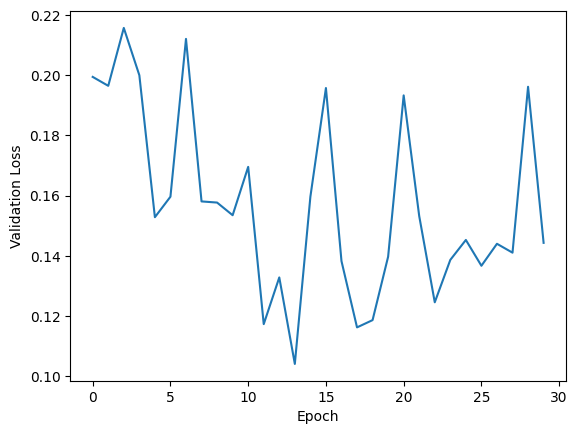

In [20]:
plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.savefig(f'{evaluations_save_folder}/validation_loss.png')

In [21]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

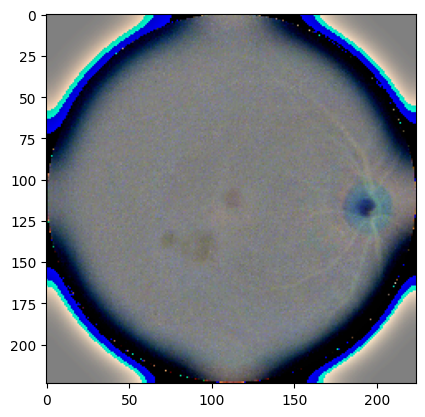

In [22]:
import random
from torchvision.transforms.functional import to_pil_image
for data, label in validation_dataset:
    #plot the image
    if random.random() < 0.5:
        plt.imshow(to_pil_image(data))
        plt.show()
        break

In [32]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

6536 560 182


In [ ]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(labels_to_encode)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', labels_to_encode[i], 'at', best_thresholds[i], 'with a score of', best_score)
#save the best thresholds
model_config = {
    'best_thresholds': best_thresholds
}

best_thresholds = torch.Tensor(best_thresholds)



In [24]:
print('Best thresholds:', best_thresholds)


Best thresholds: tensor([0.4600, 0.0700, 0.4100, 0.5200, 0.0400, 0.2800, 0.7000, 0.3100, 0.2900,
        0.1900, 0.7700, 0.2200])


In [25]:
#save the best thresholds in the model configuration
model_config['best_thresholds'] = best_thresholds.tolist()
with open(f'{best_model_save_folder}/model_config.json', 'w') as f:
    json.dump(model_config, f)

In [26]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

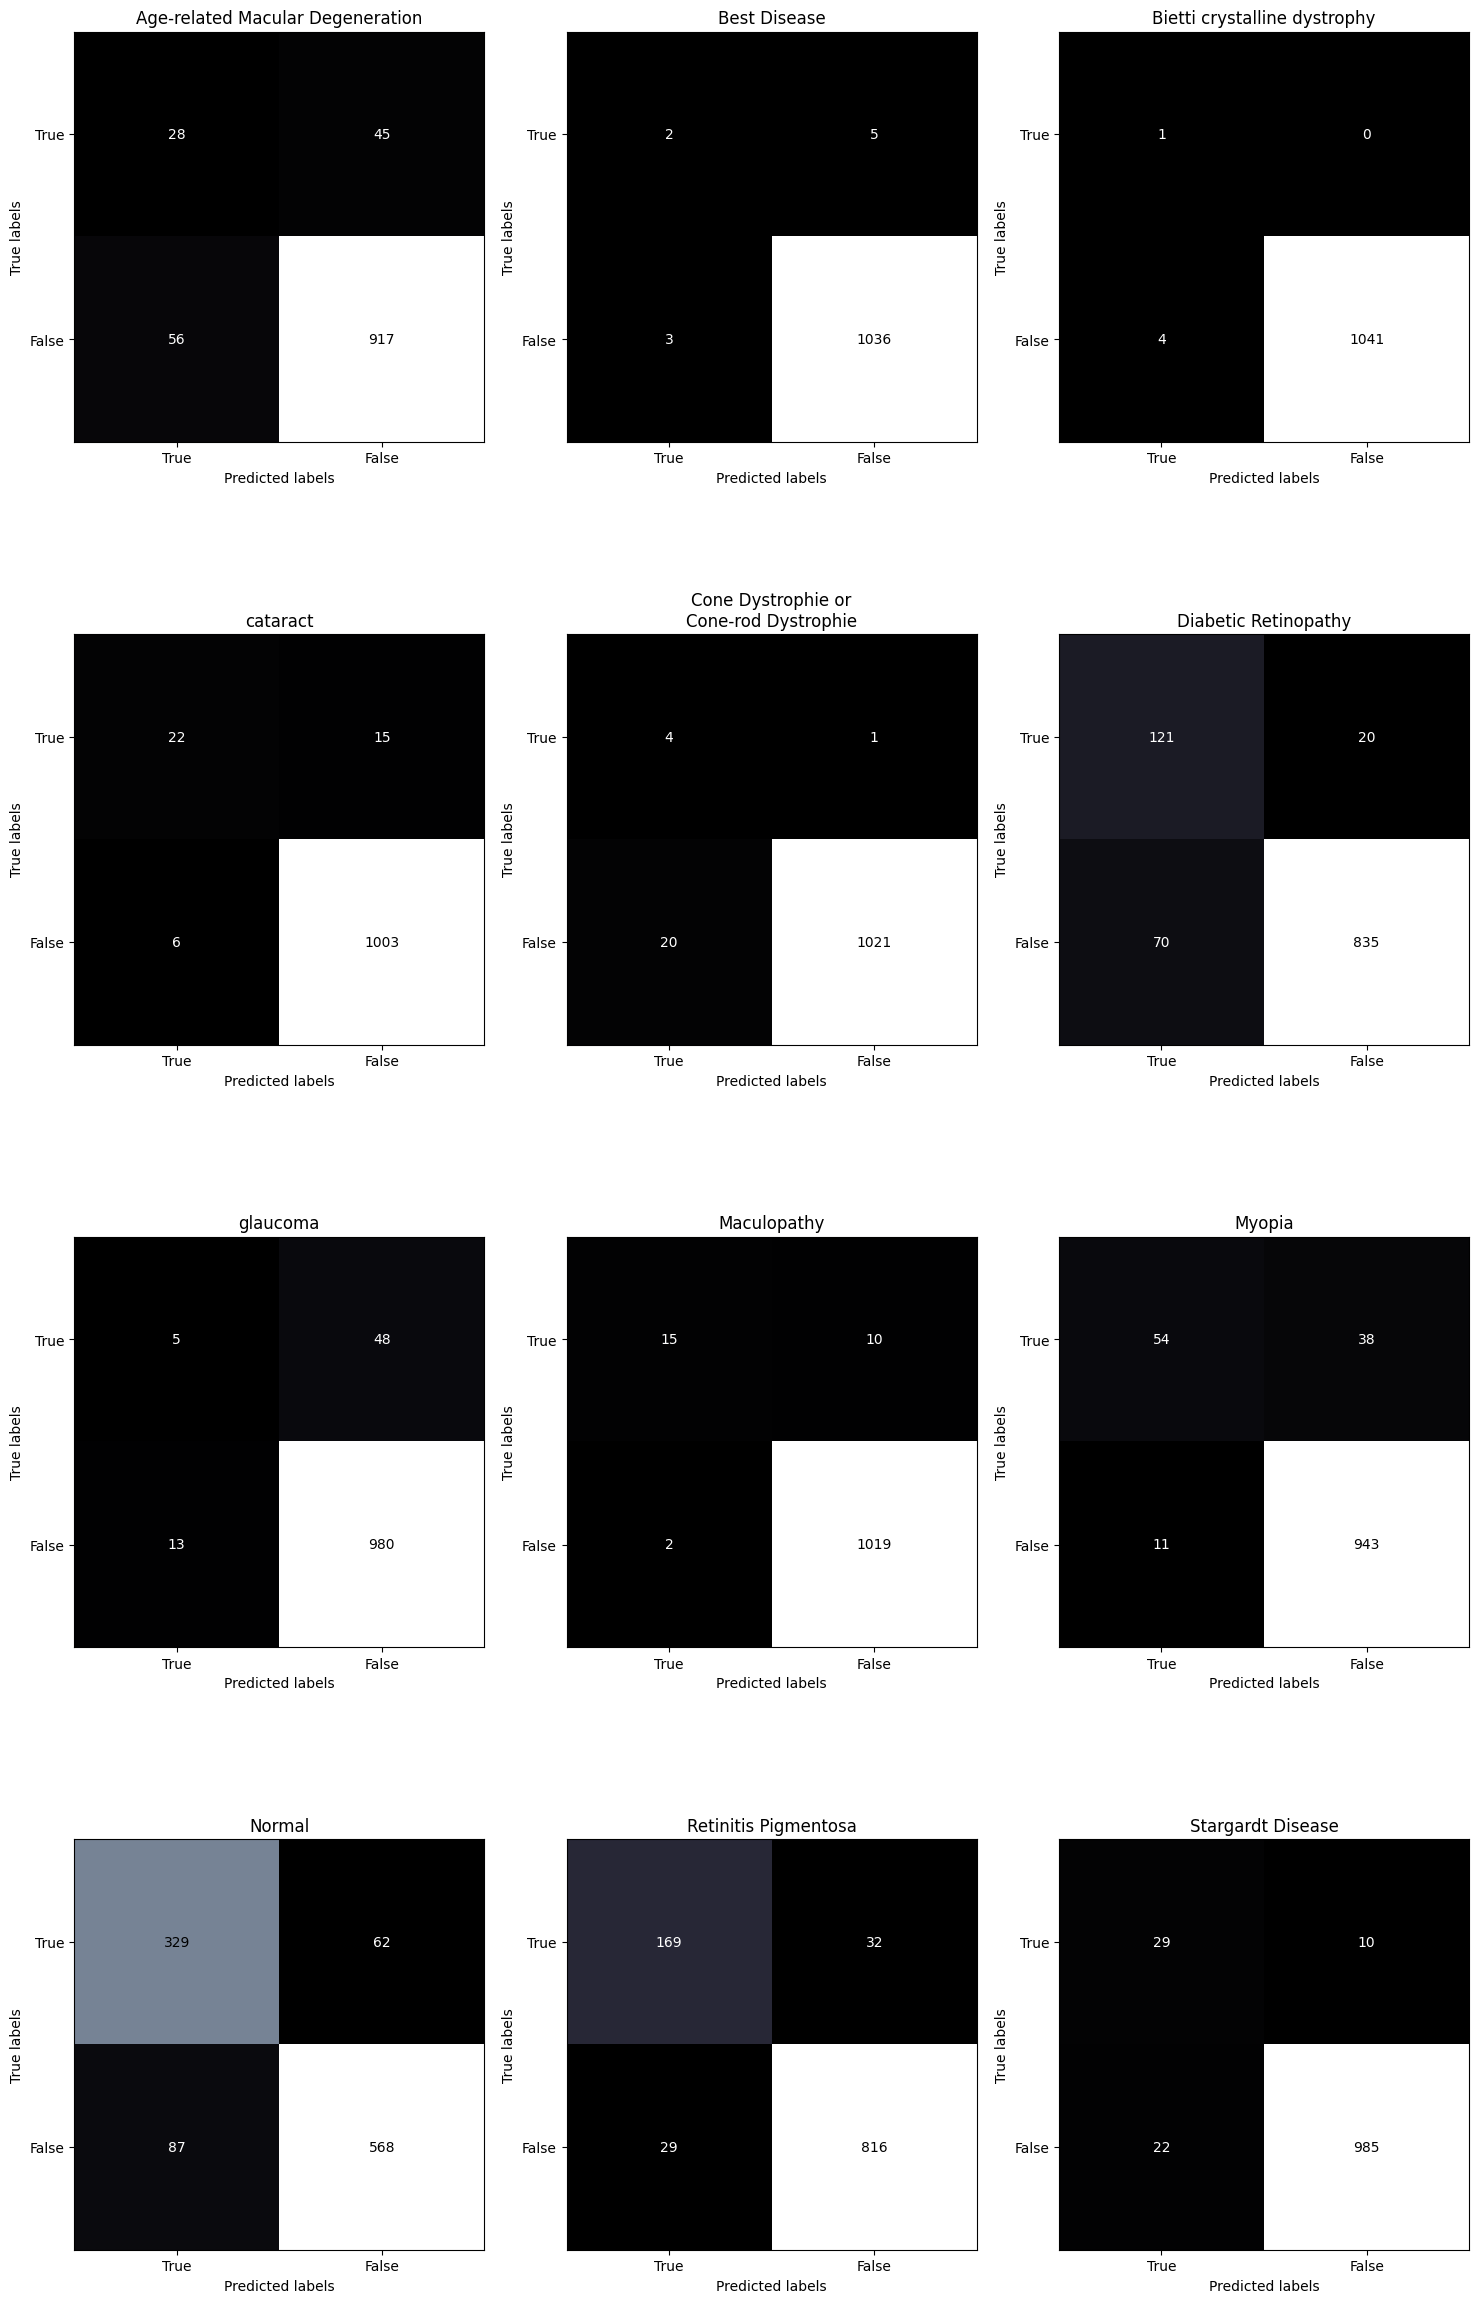

In [27]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
#save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices.png')

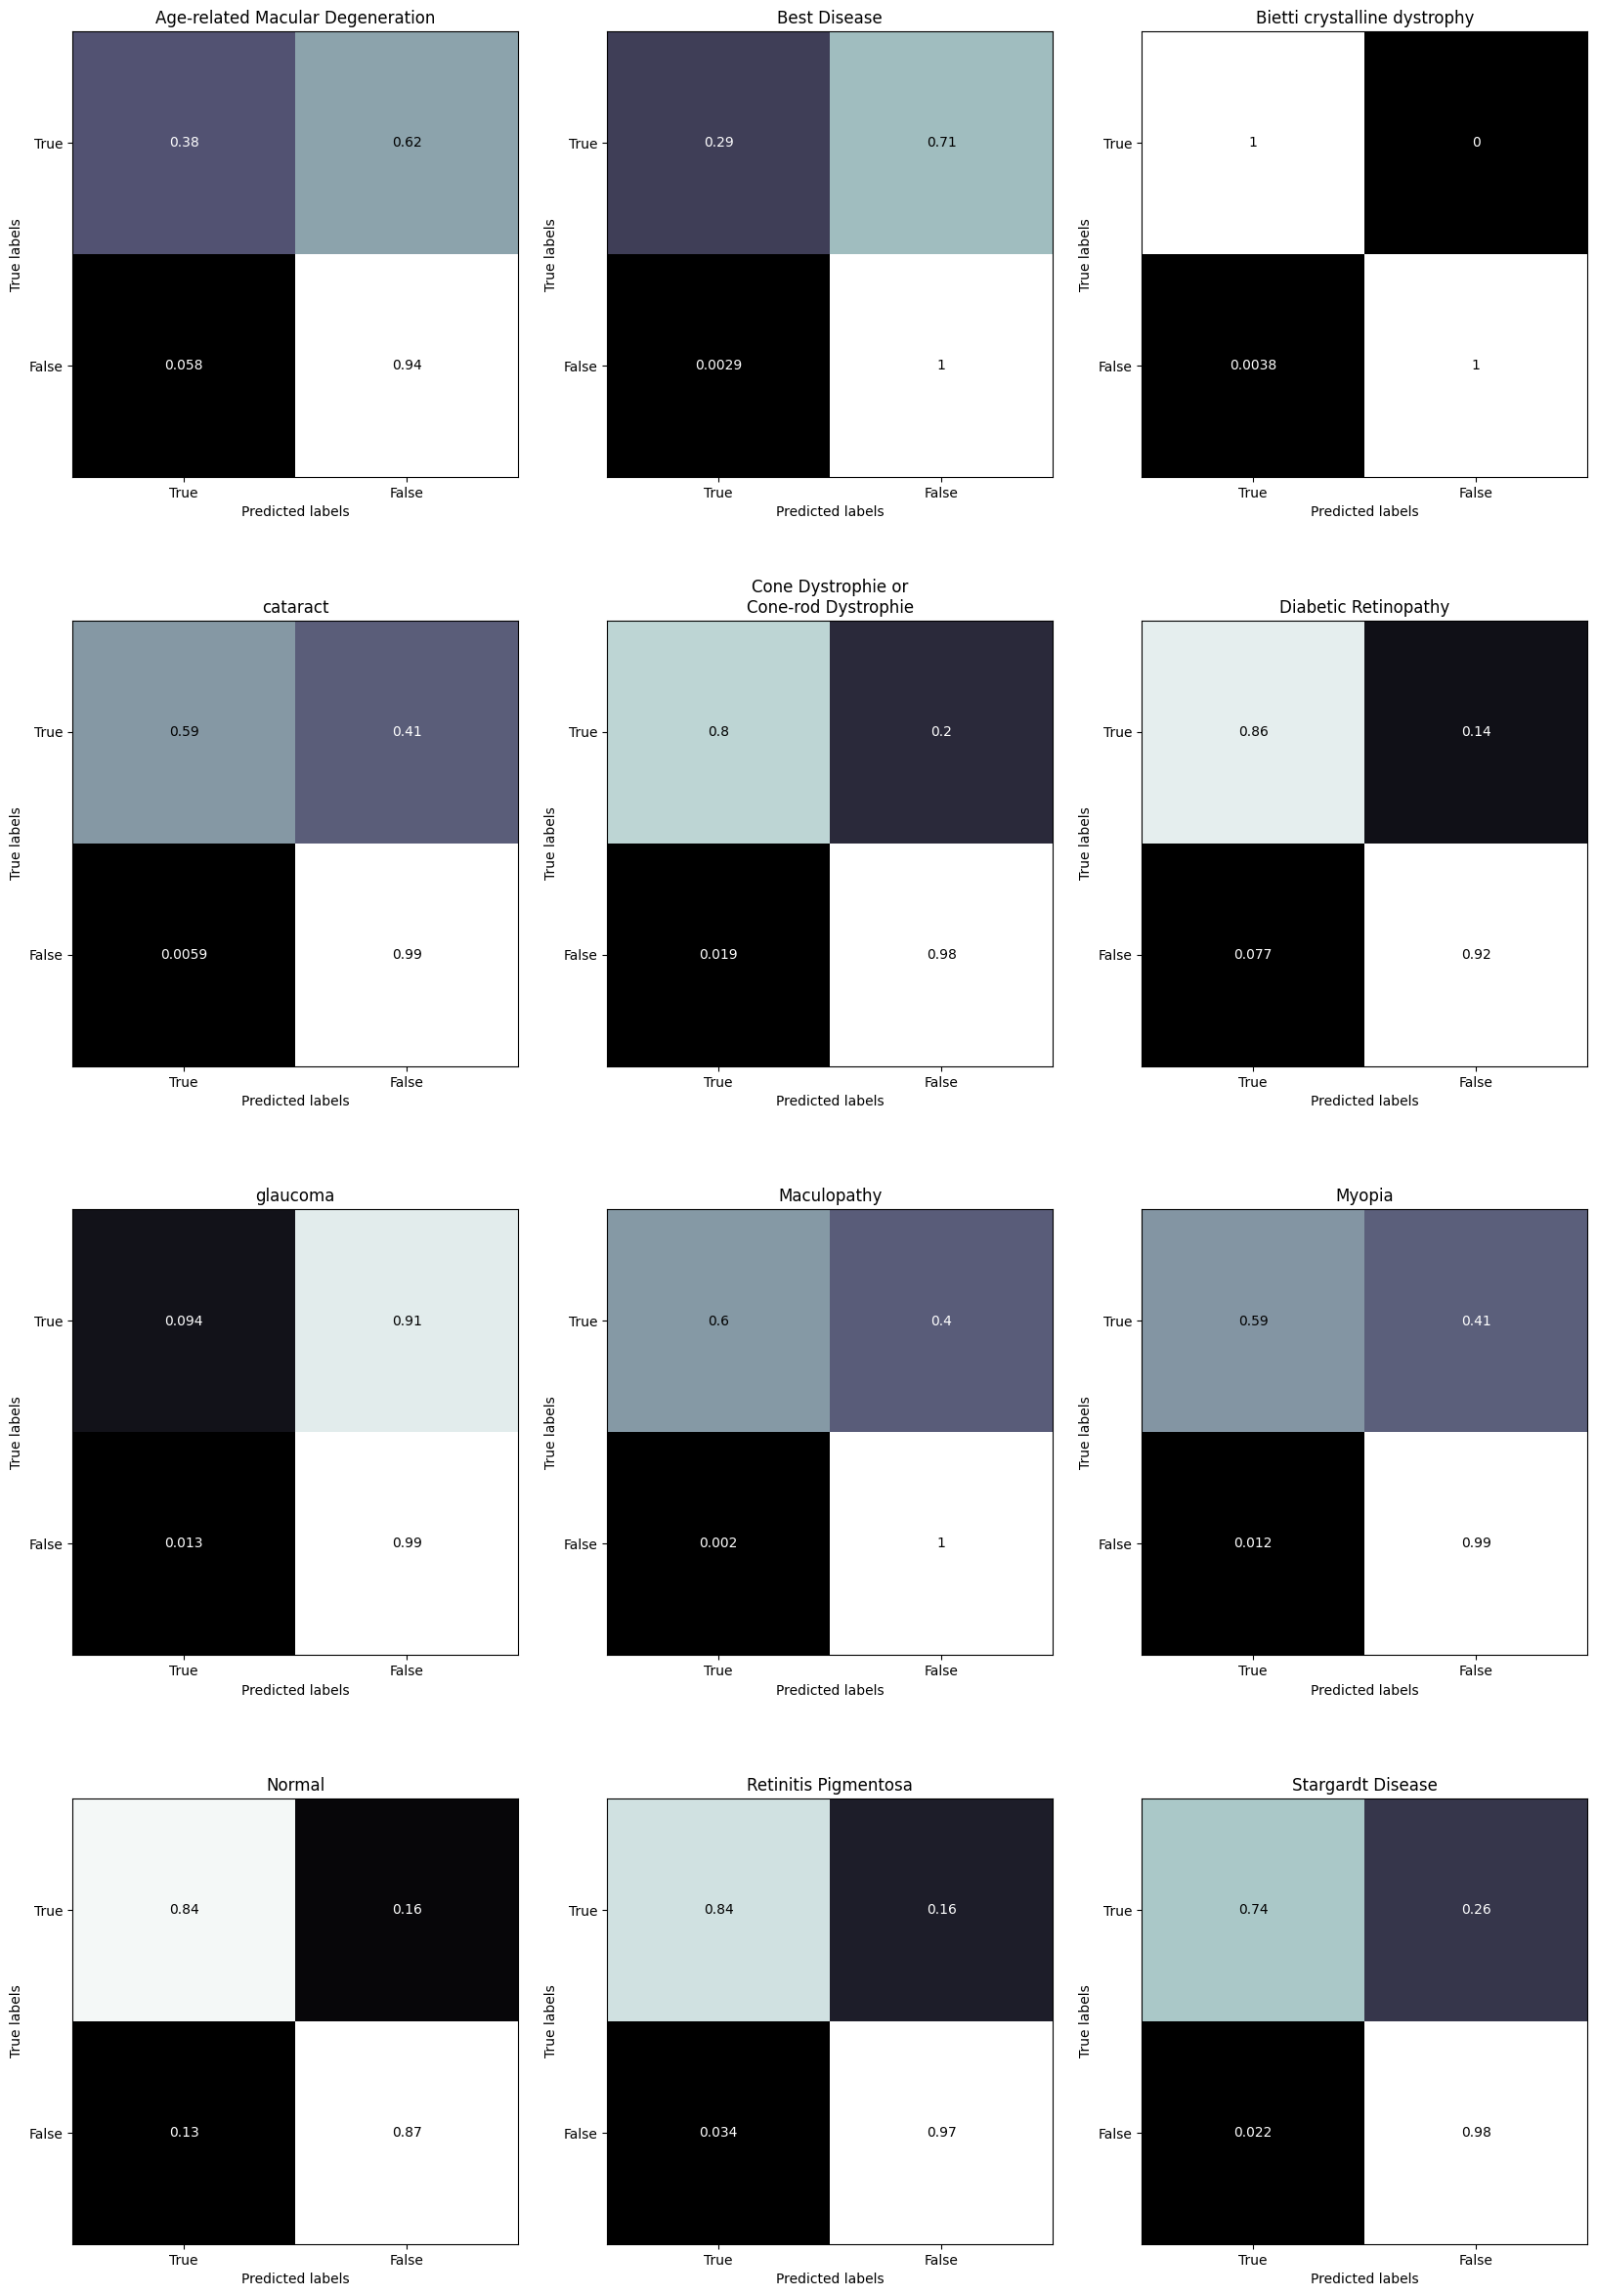

In [28]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalized_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalized_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    #save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices_normalized.png')

In [29]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision_macro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall_macro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy_macro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1_macro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
#do the same for the micro scores
precision_micro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall_micro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy_micro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1_micro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)

#save the evaluation metrics in a dictionary
evaluation_metrics = {
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'accuracy_macro': accuracy_macro,
    'f1_macro': f1_macro,
    'precision_micro': precision_micro,
    'recall_micro': recall_micro,
    'accuracy_micro': accuracy_micro,
    'f1_micro': f1_micro
}
#save the evaluation metrics
with open(f'{evaluations_save_folder}/evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f)

TP: 779
FP: 323
TN: 11164
FN: 286
-----------------------------------


In [30]:
#calculate the metrics for every test dataset
#best_thresholds = best_thresholds.cpu().numpy()
score_dict = {'data_source' : [], 'f1_micro' : [], 'f1_macro': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'accuracy_micro': [], 'accuracy_macro': []}
for test_dataset, matching_package in zip(test_datasets, test_packages):
    y_true_single = []
    y_pred_single = []
    x_single = []
    model.to(device)
    model.eval()
    single_test_loader = DataLoader(test_dataset, batch_size=164, num_workers=num_workers)
    with torch.no_grad():
        for inputs, labels in single_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_true_single.append(labels.detach().clone())
            y_pred_single.append(outputs.detach().clone())
            x_single.append(inputs.detach().clone())
    y_true_single = torch.cat(y_true_single, dim=0).cpu()
    y_pred_single = torch.cat(y_pred_single, dim=0).cpu()
    x_single = torch.cat(x_single, dim=0).cpu()
    y_pred_single_cm = torch.sigmoid(y_pred_single) > torch.Tensor(best_thresholds)
    #calculate precision, recall, accuracy and f1 score
    precision = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    recall = multi_label_recal(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    accuracy = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
    f1 = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='macro', threshold=best_thresholds)
    #and micro scores
    precision_micro = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    recall_micro = multi_label_recal(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    accuracy_micro = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
    f1_micro = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='micro', threshold=best_thresholds)
    #save the scores
    score_dict['data_source'].append(matching_package.data_source_name)
    score_dict['f1_micro'].append(f1_micro)
    score_dict['f1_macro'].append(f1)
    score_dict['precision_micro'].append(precision_micro)
    score_dict['precision_macro'].append(precision)
    score_dict['recall_micro'].append(recall_micro)
    score_dict['recall_macro'].append(recall)
    score_dict['accuracy_micro'].append(accuracy_micro)
    score_dict['accuracy_macro'].append(accuracy)

#save the scores to a json file
with open(f'{evaluations_save_folder}/break_down_scores.json', 'w') as f:
    json.dump(score_dict, f)


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (tr

In [33]:
print(score_dict)

{'data_source': ['ODIR-5K', 'RFMiD', 'RFMiD', 'RFMiD', 'RFMiD2', 'RFMiD2', 'RFMiD2', '1000images', 'RIPS', 'SES', 'UKB'], 'f1_micro': [0.5668449197860962, 0.7799043062200958, 0.7692307692307693, 0.8000000000000002, 0.9473684210526315, 0.888888888888889, 0.9285714285714286, 0.7252747252747251, 0.9666666666666667, 0.5846153846153846, 0.8140161725067385], 'f1_macro': [0.23390826044975277, 0.24117403720253708, 0.2354948977592661, 0.24743063141381705, 0.23202394313505426, 0.125, 0.2464788732394366, 0.35324402768475105, 0.08192090395480227, 0.1861512887662794, 0.1310920066693694], 'precision_micro': [0.5938375350140056, 0.7342342342342343, 0.7534246575342466, 0.7567567567567568, 0.9473684210526315, 0.9230769230769231, 0.8666666666666667, 0.6346153846153846, 0.9666666666666667, 0.48717948717948717, 0.798941798941799], 'precision_macro': [0.2532899813650977, 0.2523187052598817, 0.24989604989604994, 0.242296918767507, 0.23072916666666665, 0.125, 0.24305555555555555, 0.34479166666666666, 0.08333

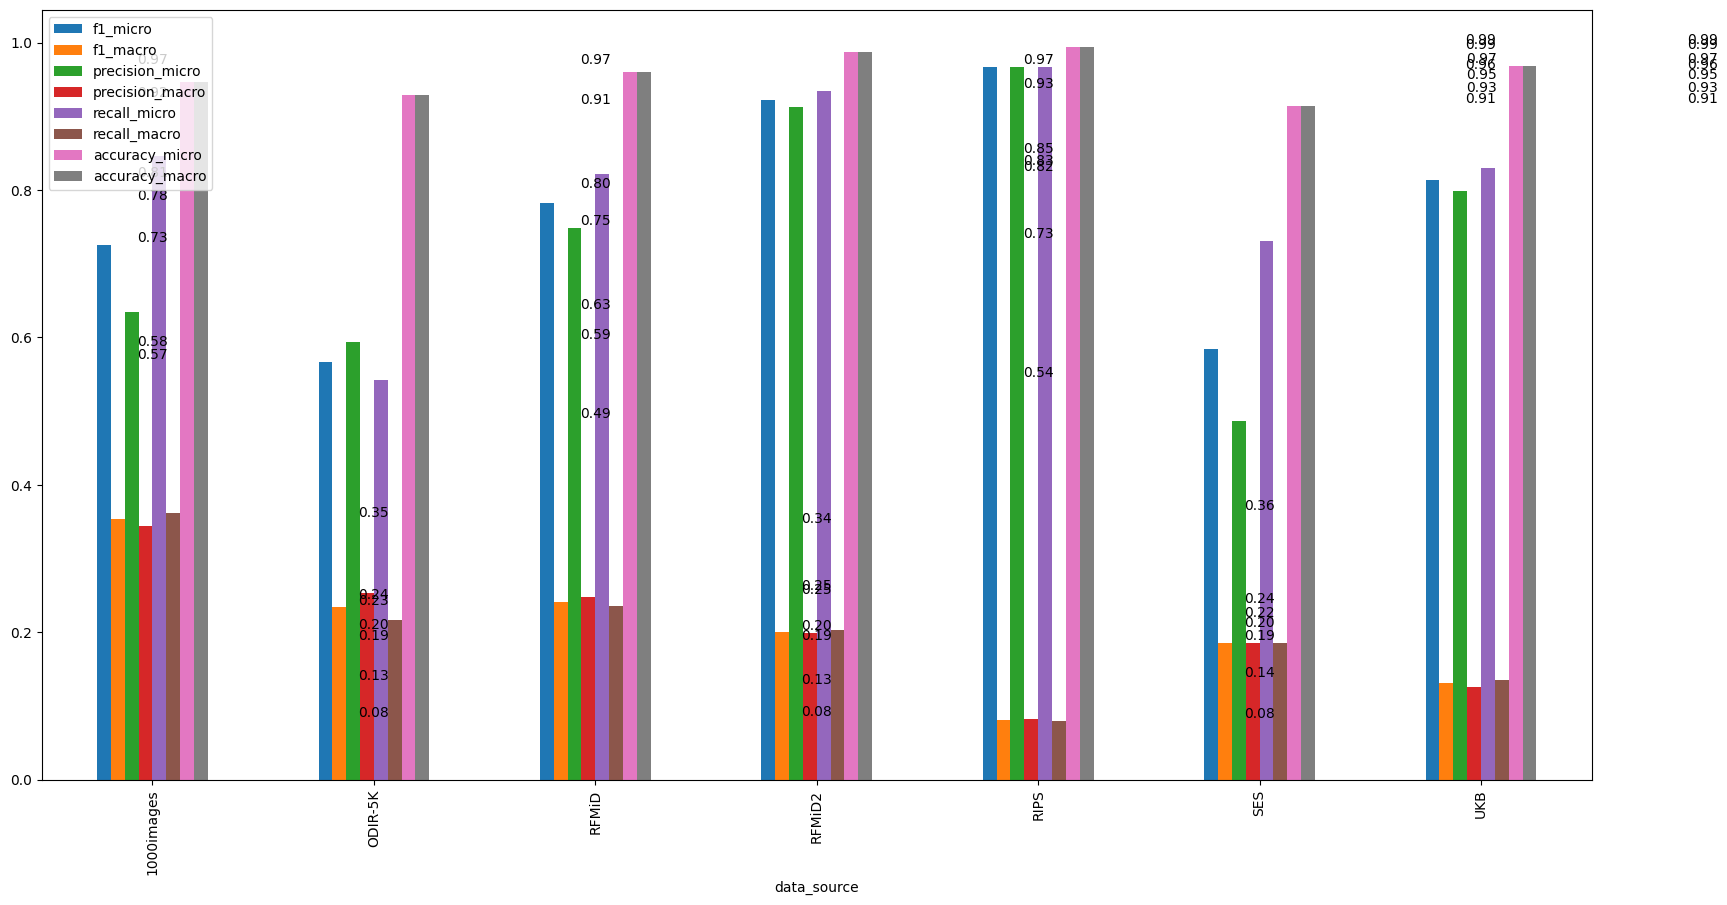

In [34]:
#create a pandas dataframe from the score dict
score_df = pd.DataFrame(score_dict)
#group the scores by data source
grouped_scores = score_df.groupby('data_source').mean()
#plot the grouped scores
grouped_scores.plot(kind='bar', figsize=(20, 10))
#annotate the bars with the values
for i, row in grouped_scores.iterrows():
    for j, value in enumerate(row):
        plt.text(j, value, f'{value:.2f}', ha='center', va='bottom')
plt.savefig(f'{evaluations_save_folder}/grouped_scores.png')
plt.show()